In [30]:
# pytorch
import torch
from torch import nn

# computer vision
import torchvision
from torchvision import transforms

from torch.utils.data import DataLoader

# data charting
import matplotlib.pyplot as plt

# Data

- FashionMNIST dataset with total of 70,000 data points and 10 classes.

- Each image is a gray-scale 24x24 image.

- Used to classify different items of clothing.

In [31]:
# Downloading the data
train_data = torchvision.datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = transforms.ToTensor(),
    target_transform = None
)

test_data = torchvision.datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = transforms.ToTensor(),
    target_transform = None
)

In [32]:
# Classes of our data
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [33]:
# Checking shape and labels
image, label = train_data[0]

print(image.shape)                  # color channels, height, width
print()
print(train_data.classes[label])    # the label for the image

torch.Size([1, 28, 28])

Ankle boot


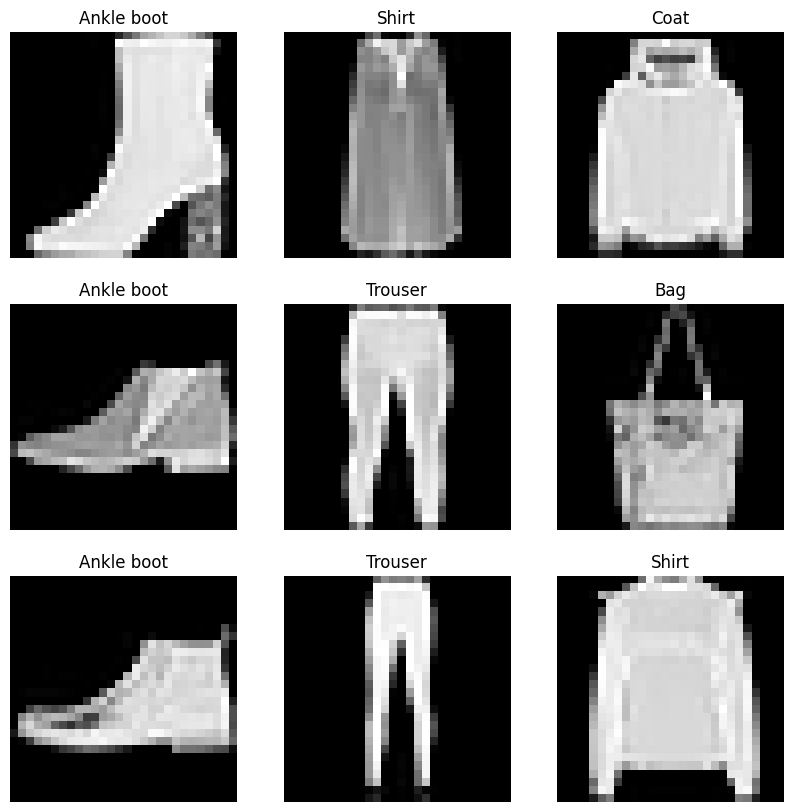

In [34]:
# Looking at a few random data points
fig = plt.figure(figsize = [10,10])
rows, cols = 3, 3
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(low = 0, high = len(train_data), size = [1]).item()
    img, label_id = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap = 'gray')
    plt.title(train_data.classes[label_id])
    plt.axis(False)

In [35]:
# Move to DataLoader
batch_size = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = batch_size,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = batch_size * 2)   # Testing doesn't need gradients, more memory

In [39]:
# Number of batches
print(f"Length of the dataloader: {len(train_dataloader)}")
print()
print(f'{len(train_dataloader)} * {batch_size} = {len(train_dataloader) * batch_size}')
print()
print(f"Length of the dataset: {len(train_data)}")

Length of the dataloader: 1875

1875 * 32 = 60000

Length of the dataset: 60000
